In [91]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from helpers import *
from matplotlib import pyplot as plt
import numpy as np
from experiment_random import *
import pandas as pd
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# probability of failure
p = 1e-2

# layers configuration
N = [50, 51, 52, 53]

# some inputs to test on
np.random.seed(42)
data = np.random.randn(5, N[0]) + 0.1

In [93]:
def compute_error_for_crashes(fail_layers, repetitions = 10000, seed = 42):
    """ Compute error on data experimentally if layers from
        fail_layers are crashed, return mean and std
    """
    
    # sanity check
    assert(len(fail_layers) == len(N))
    
    # obtaining p_inference: failing layers from fail_layers
    p_inference = [p if fail_layers[i] else 0 for i in range(len(fail_layers))]
    
    # fixing the random seed to obtain the same weights each time
    np.random.seed(seed)
    
    # creating the experiment
    exp = RandomExperiment(N, p_inference = p_inference, activation = 'relu',
                           std_weight = 3, mean_weight = 0.1, do_print = False)
    
    # computing error manually
    errors = exp.compute_error(data, repetitions = repetitions)
    
    # returning mean and std
    return np.mean(errors, axis = 1), np.std(errors, axis = 1) ** 2

In [94]:
def boolean_cube(size):
    """ Return a boolean cube of length size """
    if size == 1:
        return [[0], [1]]
    else:
        r = boolean_cube(size - 1)
        return [[0] + x for x in r] + [[1] + x for x in r]

In [95]:
# sanity check
assert boolean_cube(2) == [[0, 0], [0, 1], [1, 0], [1, 1]], "Boolean cube must return the correct value"

In [96]:
# obtaining boolean cube (fail all possible layer configurations, including input)
cube = boolean_cube(len(N))
cube = [tuple(x) for x in cube]

In [97]:
# obtaining data for each configuration
results = {conf: compute_error_for_crashes(conf, repetitions = 50000) for conf in tqdm(cube)}



  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:05<01:18,  5.25s/it]

 12%|█▎        | 2/16 [00:10<01:15,  5.38s/it]

 19%|█▉        | 3/16 [00:16<01:10,  5.40s/it]

 25%|██▌       | 4/16 [00:22<01:05,  5.50s/it]

 31%|███▏      | 5/16 [00:27<01:00,  5.54s/it]

 38%|███▊      | 6/16 [00:33<00:55,  5.58s/it]

 44%|████▍     | 7/16 [00:39<00:50,  5.66s/it]

 50%|█████     | 8/16 [00:45<00:46,  5.76s/it]

 56%|█████▋    | 9/16 [00:51<00:40,  5.81s/it]

 62%|██████▎   | 10/16 [00:58<00:37,  6.22s/it]

 69%|██████▉   | 11/16 [01:04<00:30,  6.16s/it]

 75%|███████▌  | 12/16 [01:10<00:24,  6.22s/it]

 81%|████████▏ | 13/16 [01:17<00:19,  6.34s/it]

 88%|████████▊ | 14/16 [01:24<00:13,  6.51s/it]

 94%|█████████▍| 15/16 [01:30<00:06,  6.43s/it]

100%|██████████| 16/16 [01:37<00:00,  6.46s/it]



In [98]:
def disjoint(a, b):
    """ Returns true iff configurations a and b are disjoint """
    for x, y in zip(a, b):
        if x and y: return False
    return True

def s(a, b):
    """ Returns the sum of tuples, element-wise """
    return tuple([x + y for x, y in zip(a, b)])

def leq(a, b):
    """ True iff a <= b lexicographically """
    for x, y in zip(a, b):
        if x > y: return False
        if x < y: return True
    return True

In [99]:
all_mean = []
all_std = []
# loop over the cube
for a in cube:
    # second loop over the cube
    for b in cube:
        # if a and b are disjoint and a <= b and a is not trivial
        if disjoint(a, b) and leq(a, b) and a != (0,0,0,0):
            # sum of a, b
            c = s(a, b)
            
            # a: mean and std
            da_mean, da_std = results[a]
            
            # b: mean and std
            db_mean, db_std = results[b]
            
            # sum(a, b): mean and std
            dc_mean, dc_std = results[c]
            
            # difference in mean from linearity
            dx_mean = dc_mean - da_mean - db_mean
            
            # difference in std from linearity
            dx_std  = dc_std - da_std - db_std
            
            # printing results
            all_mean += [np.linalg.norm(dx_mean) / np.linalg.norm(dc_mean)]
            all_std  += [np.linalg.norm(dx_std)/ np.linalg.norm(dc_std)]

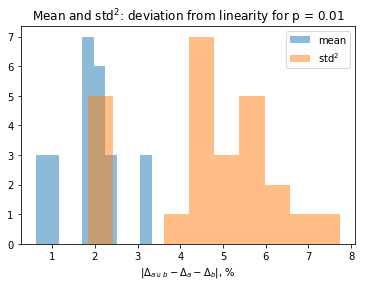

In [104]:
plt.title('Mean and std$^2$: deviation from linearity for p = %.2f' % p)
plt.hist(np.array(all_mean) * 100, alpha = 0.5, label = 'mean')
plt.hist(np.array(all_std) * 100, alpha = 0.5, label = 'std$^2$')
plt.xlabel('$\|\Delta_{a\cup b}-\Delta_a-\Delta_b\|$, %')
plt.legend()
plt.savefig('figures/error_additivity_mean_std.eps', bbox_inches = 'tight')
plt.show()